# Search, filter and download satellite imagery from planet.com

This notebook is a mishmash of several notebooks, most of them provided by planet.com on GitHub.

In [1]:
import numpy as np
import pandas as pd
import geopandas 
import planet as pl
import shapely
import os
import json
import requests
import time
from requests.auth import HTTPBasicAuth
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# TODO / improvements:
# - plot thumbnails, label contours
# - allow user to interactively pick specific satellite files before activation

## Planet.com API setup

In [2]:
# read API Key stored as an env variable
PLANET_API_KEY = os.getenv('PL_API_KEY')
if PLANET_API_KEY is None:
    raise Exception("key does not exist")

# Setup Planet Data API base URL:
URL = "https://api.planet.com/data/v1"

# - Setup the session
session = requests.Session()

# - Authenticate
session.auth = (PLANET_API_KEY, "")

# - Make a GET request to the Planet Data API
res = session.get(URL)

if res.status_code != 200:
    session.close()
    raise Exception("Houston, we have no Planet")

# - Setup the quick search endpoint url (used for temporary searches as this one)
quick_url = "{}/quick-search".format(URL)

## User-defined 'hyper'-parameters for imagery to be retrieved

In [3]:
# set all 'global' parameters needed to let this notebook do its job without user interaction

# if true, lots of information will be displayed
be_verbose = True
# if true, assets will neither be activated nor downloaded
dry_run = False

# - name of area of interest for which to download imagery (definitions see below)
aoi_name = "3093"
aoi_name = "3347"
#aoi_name = "Harz2"


# - basic path
basic_dir = "/media/hh/hd_internal/_data_DS/DSR"

# - directory to dump imagery into
data_dir = basic_dir + "/satelliteImages/Borneo/" + aoi_name + "/"
# data_dir = basic_dir + "/satelliteImages/" + aoi_name + "/"

# - maximal fraction of cloud cover
cloud_cover_max = 0.001 

# - minimal sun elevation: make sure it's not set too high and chimes with the season
# (that is, have an eye on the date range); in case of doubt set to zero
sun_elevation_min = 0

# - type of product
# PSScene3Band - PlanetScope 3-band Basic and Ortho Scenes
# PSScene4Band - PlanetScope 4-band Basic and Ortho Scenes **
# PSOrthoTile - PlanetScope 4-band Ortho Tiles as 25 km x 25 km UTM tiles
# SkySatScene - SkySat Basic and Ortho Scenes
# SkySatCollect -  is created by composing SkySat Ortho Scenes
# ** Note:
# - if set to 'PSScene3Band', visual and analytic scenes can be downloaded, but downloading
#   analytic ones does not make sense because they contain only 3 bands
# - if set to 'PSScene4Band', only analytical scenes with 4 bands can be downloaded
item_type = "PSScene4Band"
#item_type = "PSOrthoTile"

# - asset types (see https://api.planet.com/data/v1/asset-types/)
asset_type = (
    "analytic", # Radiometrically-calibrated analytic imagery stored as 16-bit scaled radiance, suitable for analytic applications.
    "analytic_sr", #Atmospherically-corrected analytic imagery stored as 16-bit scaled (surface) reflectance, suitable for analytic applications.
    "analytic_xml", # Radiometrically-calibrated analytic image metadata
    "ortho_analytic_dn", # Orthorectified 16-bit 4-Band DN Image
    "ortho_analytic_udm", # Orthorectified 16-bit 4-Band DN Image Unuseable Data Mask
    "ortho_visual,"
    "visual",
    "visual_xml"
)

asset_type = (
    "analytic", # Radiometrically-calibrated analytic imagery stored as 16-bit scaled radiance, suitable for analytic applications.
    "analytic_sr", #Atmospherically-corrected analytic imagery stored as 16-bit scaled (surface) reflectance, suitable for analytic applications.
    "analytic_xml", # Radiometrically-calibrated analytic image metadata
    "ortho_analytic_dn", # Orthorectified 16-bit 4-Band DN Image
    "ortho_analytic_udm", # Orthorectified 16-bit 4-Band DN Image Unuseable Data Mask
)

In [4]:
# functions needed in cells below
def dict_to_df(dict_aoi, geodf_aoi=None):
    """
    Converts dictionary of area of interest (AOI) to a geopanda dataframe
    and optionally appends it to existing geopanda dataframe
    """ 
    # convert to regular df, setting the name as row index
    df_aoi = pd.DataFrame(dict_aoi).set_index("name")
    # next, read geometry data and make them a shapely series
    aoi_shapes = []
    aoi_area = []
    for fn in df_aoi["filename_geometry"]:
        co = geopandas.read_file(fn)
        # this is the decisive step - each geopanda dataframe requires a
        # "geometry" column which must contain shapely objects        
        aoi_shapes.append(co["geometry"][0])
        # compute area
        aoi_area.append(co["geometry"][0].area)
        
    # insert series into dataframe    
    df_aoi["geometry"] = aoi_shapes
    df_aoi["area"] = aoi_area
    
    #... and convert panda dataframe to geopanda dataframe
    df_aoi = geopandas.GeoDataFrame(df_aoi)
    if geodf_aoi is not None:
        return geodf_aoi.append(df_aoi, verify_integrity=True)
    else:
        return df_aoi
    
# initialize geodf_aoi
geodf_aoi = None

## Define all potential areas of interest (AOI)
Notes on some parameters:
* fraction_img_inAOI_min: each image must be contained in the AOI by this fraction or more; values must range from zero to unity. Choose a large value if your AOI is much larger than the typical satellite image and you want the images to be mostly inside the AOI. In case of doubt, set to zero.
* fraction_AOI_covered_min: minimal fraction of AOI covered by image; values must range from zero to unity. Set to high values (even unity) if your AOI is decidedly smaller than the typical satellite image and you want your AOI to be mostly or completely covered by any image. Set to zero in case of doubt.


In [5]:
dict_aoi = {
    "name": "3093",     # keys correspond to numeric code of Laurance lab (e.g. 3093)
    "descript": "Borneo, labels by Laurance group",
    "filename_geometry": (basic_dir + "/road_data_Laurance/3093/boundingBox_3093.geojson"),
    "date_label_min" : "2005-11-08T00:00:00.000Z", # earliest date of labeled road
    "date_label_max" : "2017-12-31T00:00:00.000Z", # latest date of labeled road
    "date_retrieve_min" : "2017-08-01T00:00:00.000Z", # earliest date of imagery to be retrieved
    "date_retrieve_max" : "2018-08-14T00:00:00.000Z", # latest date of imagery to be retrieved
    "fraction_img_inAOI_min": [0.75], # minimal fraction of image contained in the AOI [0 1] 
    "fraction_AOI_covered_min": [0.0], # minimal fraction of AOI covered by image [0 1]
}

# convert/append to geopanda dataframe
geodf_aoi = dict_to_df(dict_aoi, geodf_aoi)

In [6]:
dict_aoi = {
    "name": "3347",     # keys correspond to numeric code of Laurance lab (e.g. 3093)
    "descript": "Borneo, labels by Laurance group",
    "filename_geometry": (basic_dir + "/road_data_Laurance/3347/boundingBox_3347_a_withPaved.geojson"),
    "date_label_min" : "n.d.", # earliest date of labeled road
    "date_label_max" : "n.d.", # latest date of labeled road
    "date_retrieve_min" : "2017-08-01T00:00:00.000Z", # earliest date of imagery to be retrieved
    "date_retrieve_max" : "2018-08-14T00:00:00.000Z", # latest date of imagery to be retrieved    "fraction_img_inAOI_min": [0.75], # minimal fraction of image contained in the AOI [0 1] 
    "fraction_img_inAOI_min": [0.5], # minimal fraction of image contained in the AOI [0 1] 
    "fraction_AOI_covered_min": [0.25], # minimal fraction of AOI covered by image [0 1]
}

# convert/append to geopanda dataframe
geodf_aoi = dict_to_df(dict_aoi, geodf_aoi)

In [7]:
dict_aoi = {
    "name": "Harz2",     #
    "descript": "Harz AOI2, with more paved roads",
    "filename_geometry": (basic_dir + "/road_data_Harz/boundingBox_Harz2.geojson"),
    "date_label_min" : "n.d.", # earliest date of labeled road
    "date_label_max" : "n.d.", # latest date of labeled road
    "date_retrieve_min" : "2018-01-01T00:00:00.000Z", # earliest date of imagery to be retrieved
    "date_retrieve_max" : "2018-08-15T00:00:00.000Z", # latest date of imagery to be retrieved
    "fraction_img_inAOI_min": [0.5], # minimal fraction of image contained in the AOI [0 1] 
    "fraction_AOI_covered_min": [0.0], # minimal fraction of AOI covered by image [0 1]
}

# convert/append to geopanda dataframe
geodf_aoi = dict_to_df(dict_aoi, geodf_aoi)

In [8]:
# peek
geodf_aoi.head()

,descript,filename_geometry,date_label_min,date_label_max,date_retrieve_min,date_retrieve_max,fraction_img_inAOI_min,fraction_AOI_covered_min,geometry,area
name,,,,,,,,,,
3093,"Borneo, labels by Laurance group",/media/hh/hd_internal/_data_DS/DSR/road_data_L...,2005-11-08T00:00:00.000Z,2017-12-31T00:00:00.000Z,2017-08-01T00:00:00.000Z,2018-08-14T00:00:00.000Z,0.75,0.00,POLYGON Z ((115.7397189289545 -1.6808368712584...,0.243744
3347,"Borneo, labels by Laurance group",/media/hh/hd_internal/_data_DS/DSR/road_data_L...,n.d.,n.d.,2017-08-01T00:00:00.000Z,2018-08-14T00:00:00.000Z,0.50,0.25,POLYGON Z ((115.9932930355558 -0.7435603582825...,0.051336
Harz2,"Harz AOI2, with more paved roads",/media/hh/hd_internal/_data_DS/DSR/road_data_H...,n.d.,n.d.,2018-01-01T00:00:00.000Z,2018-08-15T00:00:00.000Z,0.50,0.00,"POLYGON ((10.33847808837891 51.79205440859987,...",0.020719


## Other setup

In [9]:
# Functions

# Helper function to print formatted JSON using the json module
def p(data):
    print(json.dumps(data, indent=2))

# Function to download asset files
def download_ass(url, data_dir="~/Downloads/", filename=None):
    """Downloads asset files from given site; input variables:
       - url (the location url)
       - data_dir - directory (default: ~/Downloads/)
       - filename (the filename to save it as. defaults to whatever the file is called originally)
    """
    # Send a GET request to the provided location url, using API Key for authentication
    res = requests.get(url, stream=True, auth=(PLANET_API_KEY, ""))
    # If no filename argument is given
    if not filename:
        # Construct a filename from the API response
        if "content-disposition" in res.headers:
            filename = res.headers["content-disposition"].split("filename=")[-1].strip("'\"")
        # Construct a filename from the location url
        else:
            filename = url.split("=")[1][:10]
    # Save the file
    with open(data_dir + filename, "wb") as f:
        for chunk in res.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()

    return filename

## Filters

In [10]:
# geometry filter

# the Planet API expects exactly two numbers for each coordinate point,
# so we have to eliminate any additional value that resulted from reading 
# the AOI's geojson file via geopandas/fiona (elevation?). Also, it expects 
# a surreal degree of wrapping (list of list of list of lists). So,
# - convert shapely geometry to dict
geometry_config = geodf_aoi.loc[aoi_name,"geometry"].__geo_interface__
# - pick coordinates
co = geometry_config["coordinates"]
# - for each entry keep first two values, and wrap the hell
co = [[list(pt[:2]) for pt in co[0]]]
# - reinsert
geometry_config["coordinates"] = co

geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geometry_config
}

# - date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": geodf_aoi.loc[aoi_name,"date_retrieve_min"], # greater than or equal to
    "lte": geodf_aoi.loc[aoi_name,"date_retrieve_max"]  # less than or equal to
  }
}

# - cloud coverage
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": cloud_cover_max
  }
}

# - sun elevation
sun_elevation_filter = {
  "type": "RangeFilter",
  "field_name": "sun_elevation",
  "config": {
    "gte": sun_elevation_min
  }
}

# combine filters
combined_filter = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter, sun_elevation_filter]
}

## Searching Items and Assets

In [11]:
# API request object
search_request = {
  "interval": "day",
  "item_types": [item_type], 
  "filter": combined_filter
}

# Send the POST request to the API quick search endpoint
search_result = session.post(quick_url, json=search_request)

# srj is a nested dict with the following keys at the top level:
# "_links" 
# "features" - a list of the retrieved items
# "type"
srj = search_result.json()
print("found " + str(len(srj["features"])) + " items")

found 7 items


In [12]:
# convert search results to geopanda dataframe and compute overlap with AOI
imagery_list = []
for item in srj["features"]:
    feature_prop = item["properties"]
    feature_prop["id"] = item["id"]
    # this is the important step - each geopanda dataframe requires one "geometry" column
    # which must contain shapely objects
    feature_prop["geometry"] = shapely.geometry.shape(item["geometry"])
    # helpfully, we can now also compute 
    # i. the area of the intersection of satellite image and AOI
    area_intersect = geodf_aoi.loc[aoi_name, "geometry"].intersection(feature_prop["geometry"]).area
    # ii. the fraction of the imagery contained in the AOI
    feature_prop["fraction_img_inAOI"] = area_intersect / feature_prop["geometry"].area
    # iii. the fraction of our AOI covered by the imagery
    feature_prop["fraction_AOI_covered"] = area_intersect / geodf_aoi.loc[aoi_name, "area"]
    feature_prop["link_thumbnail"] = item["_links"]["thumbnail"]
    feature_prop["link_assets"] = item["_links"]["assets"]
    
    imagery_list.append(feature_prop)
    
imagery_list = geopandas.GeoDataFrame(imagery_list, geometry="geometry")
imagery_list.head(10)    

,acquired,anomalous_pixels,cloud_cover,columns,epsg_code,fraction_AOI_covered,fraction_img_inAOI,geometry,ground_control,gsd,...,published,quality_category,rows,satellite_id,strip_id,sun_azimuth,sun_elevation,updated,usable_data,view_angle
0,2018-06-18T02:05:23.899699Z,0.01,0,9059,32750,0.064894,0.188755,POLYGON ((116.1587722537235 -0.703829195822535...,True,4.0,...,2018-06-18T14:30:29Z,standard,4406,1033,1508576,50.5,50.1,2018-06-19T04:59:44Z,0,0.0
1,2018-06-18T02:03:46.301952Z,0.01,0,8762,32750,0.234183,0.717462,"POLYGON ((115.938398311314 -0.63265972770488, ...",True,3.9,...,2018-06-18T08:04:38Z,standard,4294,0e26,1508413,51.0,49.7,2018-06-19T05:51:21Z,0,0.8
2,2018-03-11T02:01:30.781067Z,0.01,0,9097,32750,0.151145,0.432269,POLYGON ((116.0897620362691 -0.678590564222737...,True,4.0,...,2018-03-11T14:36:39Z,standard,4439,103d,1257265,95.5,54.1,2018-03-12T07:07:18Z,0,2.2
3,2018-03-11T02:01:27.649535Z,0.00,0,9089,32750,0.090255,0.258162,"POLYGON ((116.122607876573 -0.510231424495615,...",True,4.0,...,2018-03-11T14:36:39Z,standard,4440,103d,1257265,95.7,54.1,2018-03-12T07:09:14Z,0,2.2
4,2017-09-20T01:55:32.767858Z,0.01,0,8992,32750,0.301632,0.877885,POLYGON ((116.0020544182501 -0.645614482632283...,True,3.9,...,2017-09-20T10:12:07Z,standard,4418,0f17,768863,87.0,56.6,2017-12-15T02:16:45Z,0,0.9
5,2017-09-20T01:55:31.723657Z,0.01,0,9013,32750,0.305017,0.886883,POLYGON ((116.2286461995184 -0.699551231964974...,True,3.9,...,2017-09-20T10:12:07Z,standard,4415,0f17,768863,87.1,56.6,2017-12-15T02:06:05Z,0,0.9
6,2017-09-20T01:57:28.268006Z,0.01,0,8995,32750,0.032118,0.094491,POLYGON ((116.0430546572283 -0.797514213954961...,True,3.9,...,2017-09-20T10:11:51Z,standard,4369,0f28,769274,87.0,56.6,2017-12-15T09:34:21Z,0,4.2


## Second round of filtering according to image properties

In [13]:
good_ix = imagery_list.loc[:,"fraction_AOI_covered"] >= geodf_aoi.loc[aoi_name, "fraction_AOI_covered_min"]
good_ix = good_ix & (imagery_list.loc[:,"fraction_img_inAOI"] >= geodf_aoi.loc[aoi_name, "fraction_img_inAOI_min"])
imagery_list = imagery_list.loc[good_ix,:].reset_index(drop=True)
print(str(len(imagery_list)) + " items remain after filtering")
imagery_list.head()

2 items remain after filtering


,acquired,anomalous_pixels,cloud_cover,columns,epsg_code,fraction_AOI_covered,fraction_img_inAOI,geometry,ground_control,gsd,...,published,quality_category,rows,satellite_id,strip_id,sun_azimuth,sun_elevation,updated,usable_data,view_angle
0,2017-09-20T01:55:32.767858Z,0.01,0,8992,32750,0.301632,0.877885,POLYGON ((116.0020544182501 -0.645614482632283...,True,3.9,...,2017-09-20T10:12:07Z,standard,4418,0f17,768863,87.0,56.6,2017-12-15T02:16:45Z,0,0.9
1,2017-09-20T01:55:31.723657Z,0.01,0,9013,32750,0.305017,0.886883,POLYGON ((116.2286461995184 -0.699551231964974...,True,3.9,...,2017-09-20T10:12:07Z,standard,4415,0f17,768863,87.1,56.6,2017-12-15T02:06:05Z,0,0.9


<Figure size 432x288 with 0 Axes>

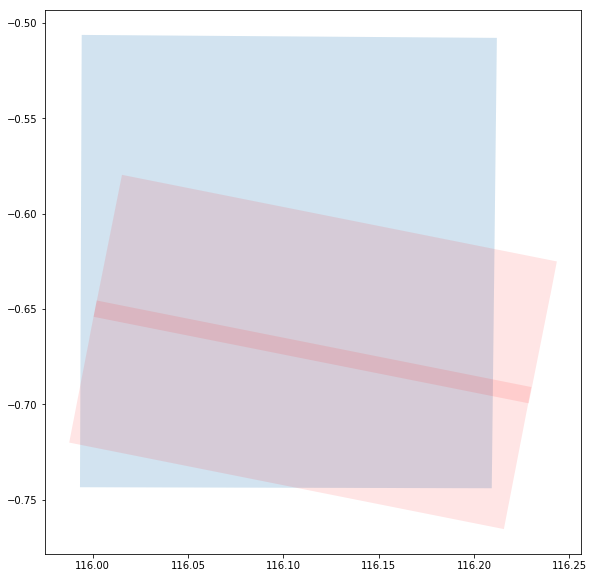

In [14]:
fig = plt.figure()
ax = geodf_aoi.loc[[aoi_name],:].plot(alpha=0.2, figsize=(10,10))
imagery_list.plot(ax=ax, color='red', alpha=0.1)

In [15]:
imagery_list.loc[1,"link_thumbnail"]

'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170920_015531_0f17/thumb'

## Activation

In [16]:
# loop over features and their assets to activate
status_count = {202 : 0, # The request has been accepted and the activation will begin shortly. 
                204: 0, # The asset is already active and no further action is needed. 
                401: 0 # The user does not have permissions to download this file.
                }

assets_get_list = []
for assets_url in imagery_list["link_assets"]:
    res = session.get(assets_url)
    # Assign a variable to the item's assets url response
    assets = res.json()
    if be_verbose:
        print("available assets: " + str(assets.keys()))
    # set of assets which are available and desired 
    assets_available = set(assets.keys()).intersection(set(asset_type))
    if be_verbose:
        print("available and requested assets: " + str(assets_available))    
    # list of assets for which we have permission to download
    assets_permitted = [key for key in assets.keys() if (assets[key]["_permissions"][0] == "download")]
    # intersection of both
    assets_get = assets_available.intersection(set(assets_permitted))
    if be_verbose:
        print("available, requested and permitted assets: " + str(assets_get))
    # put in list
    assets_get_list.append(assets_get)
    # if list is not empty:
    if (assets_available and not dry_run):
        for ass in assets_get:
            activation_url = assets[ass]["_links"]["activate"]
            # Send a request to the activation url to activate the item
            res_activation = session.get(activation_url)
            # update status count
            status_count[res_activation.status_code] += 1
            # update of list of items to get - unfisnished, not working
            #if (res_activation.status_code in [202, 204]):
            #    assets_get_list[fCount].append(ass)
            
p(status_count)           

available assets: dict_keys(['analytic', 'analytic_dn', 'analytic_dn_xml', 'analytic_sr', 'analytic_xml', 'basic_analytic', 'basic_analytic_dn', 'basic_analytic_dn_nitf', 'basic_analytic_dn_rpc', 'basic_analytic_dn_rpc_nitf', 'basic_analytic_dn_xml', 'basic_analytic_dn_xml_nitf', 'basic_analytic_nitf', 'basic_analytic_rpc', 'basic_analytic_rpc_nitf', 'basic_analytic_xml', 'basic_analytic_xml_nitf', 'basic_udm', 'udm'])
available and requested assets: {'analytic_xml', 'analytic_sr', 'analytic'}
available, requested and permitted assets: {'analytic_xml', 'analytic_sr', 'analytic'}
available assets: dict_keys(['analytic', 'analytic_dn', 'analytic_dn_xml', 'analytic_sr', 'analytic_xml', 'basic_analytic', 'basic_analytic_dn', 'basic_analytic_dn_nitf', 'basic_analytic_dn_rpc', 'basic_analytic_dn_rpc_nitf', 'basic_analytic_dn_xml', 'basic_analytic_dn_xml_nitf', 'basic_analytic_nitf', 'basic_analytic_rpc', 'basic_analytic_rpc_nitf', 'basic_analytic_xml', 'basic_analytic_xml_nitf', 'basic_udm',

## Download

In [17]:
# now check status and download once available
# note: as the downloading function is serial in nature, so is this loop
    
if ((status_count[202] + status_count[204]) > 0) and not dry_run:
    fIx = 0
    for assets_url in imagery_list["link_assets"]:
        asset_activated = False
        while asset_activated == False:           
            res = session.get(assets_url)
            # Assign a variable to the item's assets url response
            assets = res.json()
            for ass in assets_get_list[fIx]:
                ass_status = assets[ass]["status"]
                if ass_status == 'active':
                    location_url = assets[ass]["location"]
                    print(imagery_list["id"] + ": downloading " + ass + "...")
                    download_ass(location_url, data_dir=data_dir)
                    # don't forget
                    asset_activated = True
            # wait a bit before next try
            time.sleep(2)
        # increment index
        fIx += 1    
    print("done")
else:
    if not dry_run:
        print("no single item could be activated or was already activated")

0    20170920_015532_0f17: downloading analytic_xml...
1    20170920_015531_0f17: downloading analytic_xml...
Name: id, dtype: object
0    20170920_015532_0f17: downloading analytic...
1    20170920_015531_0f17: downloading analytic...
Name: id, dtype: object
0    20170920_015532_0f17: downloading analytic_xml...
1    20170920_015531_0f17: downloading analytic_xml...
Name: id, dtype: object
0    20170920_015532_0f17: downloading analytic...
1    20170920_015531_0f17: downloading analytic...
Name: id, dtype: object
done


In [18]:
# when done, close session
session.close()